In [4]:
# imports
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import adam_v2

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding, create_optimizer
from datasets import Dataset, DatasetDict

In [16]:
# load dataframe, delete article link column
pd.set_option('display.max_colwidth', None)
# there are v1 and v2
file_name = 'Sarcasm_Headlines_Dataset.json'
df = pd.read_json(file_name, lines=True)
del df['article_link']
df.head(5)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,mom starting to fear son's web series closest thing she will have to grandchild,1
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,j.k. rowling wishes snape happy birthday in the most magical way,0


In [17]:
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Preprocessing



In [18]:
def create_datasets_from_dataframe(df: pd.DataFrame):
    # split data into train and test set into 60:20:20
    train_df, test_df = train_test_split(df, train_size=0.6, shuffle=True, random_state=0)
    val_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=0)

    # create dataset objects 
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    test_dataset = Dataset.from_pandas(test_df)

    # create dataset dict with dataset objects
    datasets = DatasetDict()
    datasets['train'] = train_dataset
    datasets['val'] = val_dataset
    datasets['test'] = test_dataset
    return datasets

datasets = create_datasets_from_dataframe(df)

In [19]:
# first sentence
print(datasets['train'][0])
print(tokenizer(datasets['train'][0]['headline']))

{'headline': "bernice king says trump's racist comments are 'troubling to our humanity'", 'is_sarcastic': 0, '__index_level_0__': 17847}
{'input_ids': [0, 27598, 2463, 8453, 161, 20125, 18, 7159, 1450, 32, 128, 90, 8508, 12947, 7, 84, 9187, 108, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [20]:
# tokenize and dynamic padding with collator
def tokenize_function(item):
    return tokenizer(item['headline'],
                     padding=True,
                     truncation=True)

tokenized_datasets = datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [21]:
def convert_dataset_to_tf_dataset(dataset: Dataset):
    tf_dataset = dataset.to_tf_dataset(
        columns=["attention_mask", "input_ids"],
        label_cols=["is_sarcastic"],
        shuffle=False,
        collate_fn=data_collator,
        batch_size=32,
    )
    return tf_dataset

tf_train_dataset = convert_dataset_to_tf_dataset(tokenized_datasets['train'])
tf_val_dataset = convert_dataset_to_tf_dataset(tokenized_datasets['val'])
tf_test_dataset = convert_dataset_to_tf_dataset(tokenized_datasets['test'])

# Create and train model

In [22]:
num_of_epochs = 5

# callbacks
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [31]:
def model_builder():
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    
    optimizer, _ = create_optimizer(init_lr=5e-5,
                                    num_train_steps= len(tf_train_dataset) * num_of_epochs,
                                    num_warmup_steps=200,
                                    min_lr_ratio=0)

    model.compile(optimizer, SparseCategoricalCrossentropy(from_logits=True), ['acc'])
    return model

In [32]:
model = model_builder()
history = model.fit(tf_train_dataset,
          validation_data=tf_val_dataset,
          epochs=num_of_epochs,
          callbacks=[stop_early])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
501/501 [==============================] - 311s 580ms/step - loss: 0.3417 - acc: 0.8344 - val_loss: 0.2077 - val_acc: 0.9107
Epoch 2/5
501/501 [==============================] - 288s 574ms/step - loss: 0.1555 - acc: 0.9404 - val_loss: 0.2118 - val_acc: 0.9291
Epoch 3/5
501/501 [==============================] - 287s 573ms/step - loss: 0.0826 - acc: 0.9705 - val_loss: 0.2293 - val_acc: 0.9347
Epoch 4/5
501/501 [==============================] - 287s 573ms/step - loss: 0.0412 - acc: 0.9863 - val_loss: 0.2866 - val_acc: 0.9375


In [24]:
model = model_builder()
history = model.fit(tf_train_dataset,
          validation_data=tf_val_dataset,
          epochs=num_of_epochs,
          callbacks=[stop_early])

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
501/501 [==============================] - 311s 580ms/step - loss: 0.2956 - acc: 0.8738 - val_loss: 0.1939 - val_acc: 0.9234
Epoch 2/5
501/501 [==============================] - 287s 573ms/step - loss: 0.1406 - acc: 0.9474 - val_loss: 0.1933 - val_acc: 0.9330
Epoch 3/5
501/501 [==============================] - 287s 573ms/step - loss: 0.0731 - acc: 0.9753 - val_loss: 0.3092 - val_acc: 0.9139
Epoch 4/5
501/501 [==============================] - 287s 573ms/step - loss: 0.0372 - acc: 0.9883 - val_loss: 0.2408 - val_acc: 0.9379
Epoch 5/5
501/501 [==============================] - 288s 575ms/step - loss: 0.0167 - acc: 0.9952 - val_loss: 0.2627 - val_acc: 0.9382


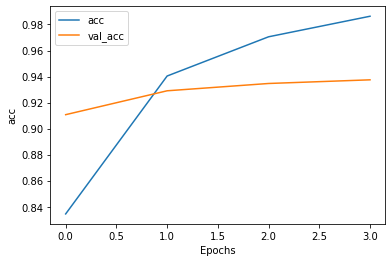

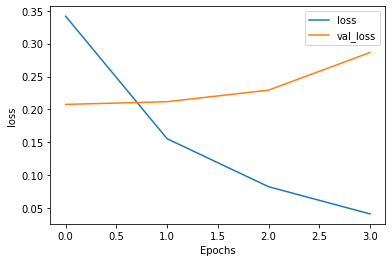

In [34]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

# Load best weights

### Besto so far
334/334 [==============================] - 44s 133ms/step - loss: 0.2593 - acc: 0.9324

In [37]:
model.config.id2label = {0: 'not_sarcastic', 1: 'is_sarcastic'}
model.save_pretrained('my-model-roberta')
tokenizer.save_pretrained('my-tokenizer-roberta')
my_model = TFAutoModelForSequenceClassification.from_pretrained('my-model-roberta')
my_model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])
loss, acc = my_model.evaluate(tf_test_dataset)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at my-model-roberta.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


167/167 [==============================] - 40s 202ms/step - loss: 0.2995 - acc: 0.9328


# Evaluate the model

In [ ]:
loss, acc = model.evaluate(tf_test_dataset)
print(f'Loss is: {loss}, acc is: {acc}')

167/167 [==============================] - 18s 109ms/step - loss: 0.2485 - acc: 0.9276
Loss is: 0.24853917956352234, acc is: 0.9275552034378052


In [38]:
predictions = my_model.predict(tf_test_dataset)
y_pred = np.argmax(predictions['logits'], axis=1)
y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3014
           1       0.95      0.90      0.92      2328

    accuracy                           0.93      5342
   macro avg       0.93      0.93      0.93      5342
weighted avg       0.93      0.93      0.93      5342



In [39]:
# predictions
raw_inputs = ["It's a beautiful day.",
              "It’s okay if you don’t like me, not everyone has good taste."]
my_tokenizer = AutoTokenizer.from_pretrained('my-tokenizer-roberta')
inputs = my_tokenizer(text=raw_inputs, padding=True, truncation=True, return_tensors='tf')
outputs = my_model(inputs)

predictions = tf.math.softmax(outputs.logits)

for pred in predictions:
    print(f'{my_model.config.id2label[0]}: {pred[0]}')
    print(f'{my_model.config.id2label[1]}: {pred[1]}')
    print('------')

not_sarcastic: 0.999309778213501
is_sarcastic: 0.0006902549066580832
------
not_sarcastic: 0.999251663684845
is_sarcastic: 0.0007483567460440099
------
